In [58]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from datetime import datetime
plt.rcParams['figure.figsize'] = [16, 8]

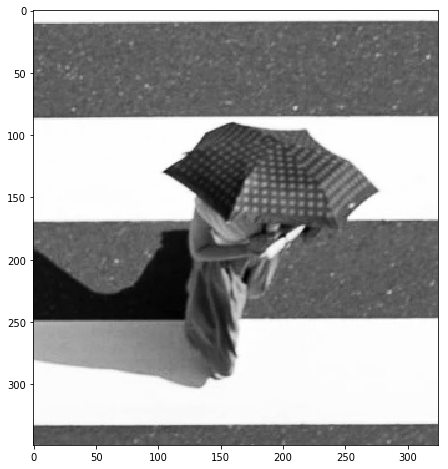

In [61]:
img = cv2.imread('umbrella.jpg',0)
plt.imshow(img,'gray')

In [62]:
def translateImg(img,dx,dy):
    i_index = np.zeros(img.shape)
    j_index = np.zeros(img.shape)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            i_index[i,j] = i
            j_index[i,j] = j

    index_mat = np.zeros((img.shape[0],img.shape[1],3))
    index_mat[:,:,0] = i_index
    index_mat[:,:,1] = j_index
    index_mat[:,:,2] = np.full(img.shape,1)
    index_mat = np.reshape(index_mat,(img.shape[0]*img.shape[1],3))

    trans_mat = np.array([[1,0,0],[0,1,0],[-dy,-dx,1]])
    trans_index = np.reshape(index_mat.dot(trans_mat),(img.shape[0],img.shape[1],3)).astype('int')
    trans_img = np.zeros(img.shape,dtype=int)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            n_i = trans_index[i,j,0]
            n_j = trans_index[i,j,1]
            if(n_i < 0) or (n_i > img.shape[0]-1):
                trans_img[i,j] = 0
            elif(n_j < 0) or (n_j > img.shape[1]-1):
                trans_img[i,j] = 0
            else:
                trans_img[i,j] = img[n_i,n_j]
    return trans_img

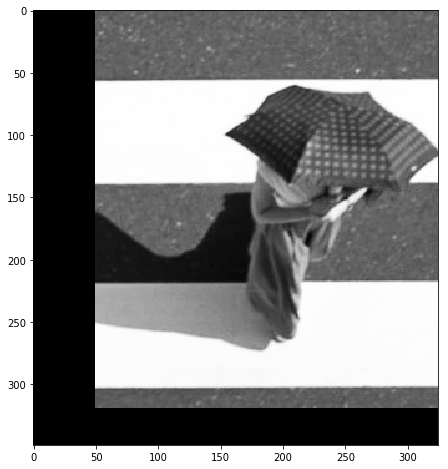

In [63]:
plt.imshow(translateImg(img,50,-30),'gray')

In [64]:
def rotateImg(img, theta, mode):
    w = nw = img.shape[1]
    h =nh = img.shape[0]
    rot_mat = np.array([[np.cos(theta),np.sin(theta),0],[-np.sin(theta),np.cos(theta),0],[0,0,1]])
    if mode == 'full':
        # calculate image size after rotation
        tl = np.round(np.array([[-h/2,-w/2,1]]).dot(rot_mat)).astype(int)
        tr = np.round(np.array([[-h/2,w/2,1]])).dot(rot_mat).astype(int)
        bl = np.round(np.array([[h/2,-w/2,1]]).dot(rot_mat)).astype(int)
        br = np.round(np.array([[h/2,w/2,1]]).dot(rot_mat)).astype(int)
        nh = np.max([tl[0,0],tr[0,0],bl[0,0],br[0,0]])*2
        nw = np.max([tl[0,1],tr[0,1],bl[0,1],br[0,1]])*2
    elif mode != 'same':
        print('Modes: "full", "Same"')
        return -1
        
    # create matrix indexes of the original image where the center pixel is [0,0] and to the left and up are negative values 
    # ex: [[(-1,-1),(-1,0),(-1,1)],
    #      [(0 ,-1),(0 ,0),(0 ,1)],
    #      [(1 ,-1),(1 ,0),(1 ,1)]]
    i_index = np.zeros((nh,nw))
    j_index = np.zeros((nh,nw))
    for i in range(nh):
        for j in range(nw):
            i_index[i,j] = i-int(nh/2)
            j_index[i,j] = j-int(nw/2)
    index_mat = np.zeros((nh,nw,3))
    index_mat[:,:,0] = i_index
    index_mat[:,:,1] = j_index
    index_mat[:,:,2] = np.full((nh,nw),1)
    index_mat = np.reshape(index_mat,(nw*nh,3))
    
    # create matrix indexes of the rotated image where the center pixel is still [0,0] but other values are rotated 
    rot_index = np.reshape(index_mat.dot(np.linalg.inv(rot_mat)),(nh,nw,3)).astype('int')
    # create the rotated images where rot_img[i,j] = rot_index[i+h/2,j+w/2] (to get back to regular coordinate system)
    rot_img = np.zeros((nh,nw),dtype=int)
    for i in range(nh):
        for j in range(nw):
            n_i = rot_index[i,j,0]+int(h/2)
            n_j = rot_index[i,j,1]+int(w/2)
            if(n_i < 0) or (n_i >h-1):
                rot_img[i,j] = 0
            elif(n_j < 0) or (n_j > w-1):
                rot_img[i,j] = 0
            else:
                rot_img[i,j] = img[n_i,n_j]
    return rot_img

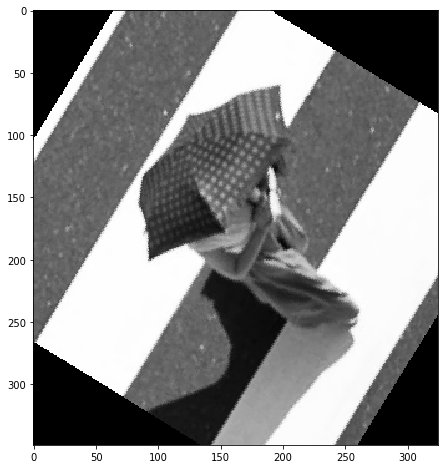

In [65]:
rotated_image = rotateImg(img,45,'same')
plt.imshow(rotated_image,'gray')

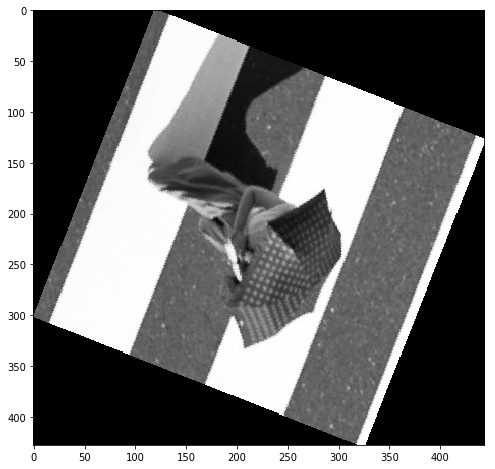

In [66]:
rotated_image = rotateImg(img,130,'full')
plt.imshow(rotated_image,'gray')

In [67]:
# def findTranslation(img):
    

In [68]:
img = cv2.imread('umbrella.jpg',0)
img2 = translateImg(img,20,40)
h,w = img.shape[:2]
min_error = error = np.inf
best = (0,0)

# for u in range(-h+1,h,100):
#     for v in range(-w+1,w,100):
for u in range(0,50,10):
    for v in range(0,50,10):
        tl = (np.max([u,0]),np.max([v,0]))
        br = (np.min([h+u-1,h-1]),np.max([w+v-1,w-1]))
        sub_size = (br[0]-tl[0])*(br[1]-tl[1])
        trans = translateImg(img,u,v)
        error = np.sum(((trans[tl[0]:br[0],tl[1]:br[1]]-img2[tl[0]:br[0],tl[1]:br[1]])**2))/sub_size
        if error < min_error:
            min_error = error
            best = (u,v)
print(best)

(20, 40)


In [69]:
def lucas_kanade_np(im1, im2, win=2):
    assert im1.shape == im2.shape
    I_x = np.zeros(im1.shape)
    I_y = np.zeros(im1.shape)
    I_t = np.zeros(im1.shape)
    I_x[1:-1, 1:-1] = (im1[1:-1, 2:] - im1[1:-1, :-2]) / 2
    I_y[1:-1, 1:-1] = (im1[2:, 1:-1] - im1[:-2, 1:-1]) / 2
    I_t[1:-1, 1:-1] = im1[1:-1, 1:-1] - im2[1:-1, 1:-1]
    params = np.zeros(im1.shape + (5,)) #Ix2, Iy2, Ixy, Ixt, Iyt
    params[..., 0] = I_x * I_x # I_x2
    params[..., 1] = I_y * I_y # I_y2
    params[..., 2] = I_x * I_y # I_xy
    params[..., 3] = I_x * I_t # I_xt
    params[..., 4] = I_y * I_t # I_yt
    del I_x, I_y, I_t
    cum_params = np.cumsum(np.cumsum(params, axis=0), axis=1)
    del params
    win_params = (cum_params[2 * win + 1:, 2 * win + 1:] -
                  cum_params[2 * win + 1:, :-1 - 2 * win] -
                  cum_params[:-1 - 2 * win, 2 * win + 1:] +
                  cum_params[:-1 - 2 * win, :-1 - 2 * win])
    del cum_params
    op_flow = np.zeros(im1.shape + (2,))
    det = win_params[...,0] * win_params[..., 1] - win_params[..., 2] **2
    op_flow_x = np.where(det != 0,
                         (win_params[..., 1] * win_params[..., 3] -
                          win_params[..., 2] * win_params[..., 4]) / det,
                         0)
    op_flow_y = np.where(det != 0,
                         (win_params[..., 0] * win_params[..., 4] -
                          win_params[..., 2] * win_params[..., 3]) / det,
                         0)
    op_flow[win + 1: -1 - win, win + 1: -1 - win, 0] = op_flow_x[:-1, :-1]
    op_flow[win + 1: -1 - win, win + 1: -1 - win, 1] = op_flow_y[:-1, :-1]
    return op_flow

d:\python\python36\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
d:\python\python36\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


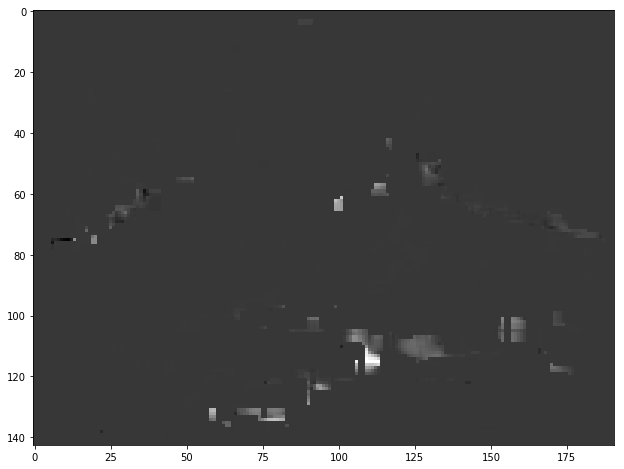

In [70]:
cars1 = cv2.imread('cars1.jpg',0)
cars2 = cv2.imread('cars2.jpg',0)
res = lucas_kanade_np(cars1,cars2)
vector_img = cars1
for i in range(0,cars1.shape[0],5):
    for j in range(0,cars1.shape[1],5):
        vector_img = cv2.arrowedLine(vector_img,(i,j),(i+int(res[i,j,0]),j+int(res[i,j,1])),0)
plt.imshow(res[:,:,1],'gray')

# Image Pyramids

In [71]:
def gauss_row(size):
    arr = np.array([1,1])
    ker = np.array([1,1])
    for i in range(size-2):
        arr = np.convolve(arr,ker)
    return arr/np.sum(arr)

def reduce(img, filter_size):
    ker = gauss_row(filter_size)
    h,w = img.shape[:2]
    res = np.zeros((int(h/2),int(w/2)))
    blurred = cv2.filter2D(img,-1,ker)
    blurred = np.transpose(blurred)
    blurred = cv2.filter2D(blurred,-1,ker)
    blurred = np.transpose(blurred)
    for i in range(int(h/2)):
        for j in range(int(w/2)):
            res[i,j] = blurred[i*2,j*2]
    return res

def expand(img, filter_size):
    ker = 2*gauss_row(filter_size)
    h,w = img.shape[:2]
    res = np.zeros((h*2,w*2))
    for i in range(h):
        for j in range(w):
            res[i*2,j*2] = img[i,j]
    res = cv2.filter2D(res,-1,ker)
    res = np.transpose(res)
    res = cv2.filter2D(res,-1,ker)
    res = np.transpose(res)
    return res

In [72]:
# def GaussianPyramid(im:np.ndarray, maxLevels:int, filterSize:int)->(list[np.ndarray],np.ndarray):
def GaussianPyramid(im:np.ndarray, maxLevels:int, filterSize:int):
    pyramids = []
    pyramids.append(im)
    ker = gauss_row(filterSize)
    for i in range(maxLevels):
        h,w = pyramids[i].shape[:2]
        if(h/2 >= 16):
            temp = reduce(pyramids[i],filterSize)
            pyramids.append(temp)
        else:
            return pyramids,ker
    return pyramids,ker

# def LaplacianPyramid(im, maxLevels, filterSize)->(list[np.ndarray],np.ndarray)
def LaplacianPyramid(im, maxLevels, filterSize):
    pyramids = []
    gauss_pyr,ker = GaussianPyramid(im,maxLevels,filterSize)
    for i in range(maxLevels-1):
        temp = expand(gauss_pyr[i+1],filterSize)
        temp = gauss_pyr[i] - temp
        pyramids.append(temp)
    pyramids.append(gauss_pyr[maxLevels-1])
    return pyramids, ker

In [73]:
# def LaplacianToImage(lpyr:List[np.ndarray],filter:np.ndarray)->np.ndarray:
def LaplacianToImage(lpyr,filt)->np.ndarray:
    maxLevels = len(lpyr)
    res = lpyr[maxLevels-1]
    for i in range(1,maxLevels):
        res = expand(res,filt.shape[0]) + lpyr[maxLevels-i-1]
    return res

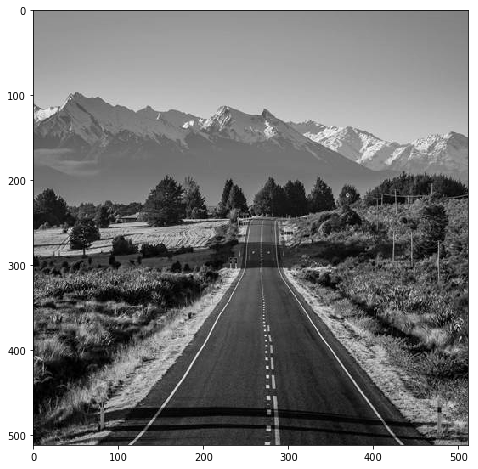

In [74]:
img = cv2.imread('road.jpg',0)
filterSize = 3
maxLevels = 5
pyr,_ = GaussianPyramid(img,maxLevels,filterSize)
pyr2,ker = LaplacianPyramid(img,maxLevels,filterSize)
l2i = LaplacianToImage(pyr2,ker)
plt.imshow(l2i,'gray')

In [75]:
def renderPyramid(pyr)->np.ndarray:
    w = 0
    h = pyr[0].shape[0]
    for im in pyr:
        w += im.shape[0]
    res = np.zeros((h,w))
    start = 0
    for j in range(len(pyr)):
        curr = pyr[j]
        size = curr.shape[0]
        res[0:size,start:start+size] = curr
        start += size
    return res

def displayPyramid(pyr)->None:
    plt.imshow(renderPyramid(pyr),'gray')

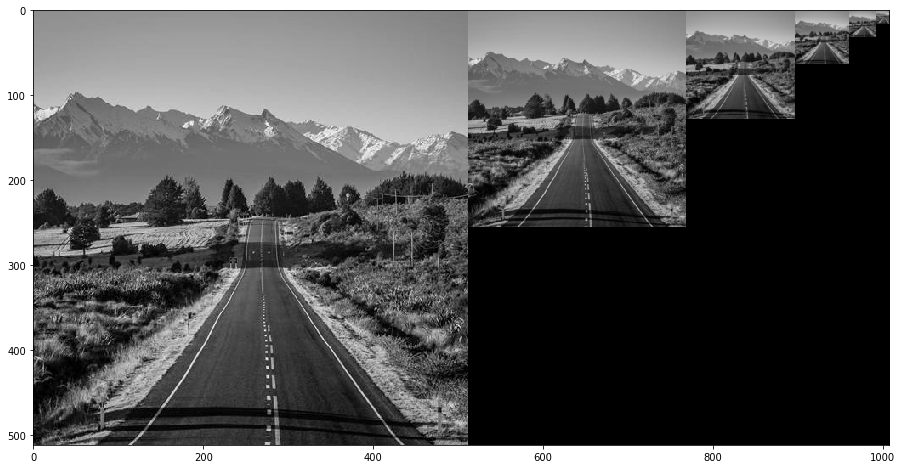

In [76]:
img = cv2.imread('road.jpg',0)
filterSize = 3
maxLevels = 6
pyr,_ = GaussianPyramid(img,maxLevels,filterSize)
# pyr2,ker = LaplacianPyramid(img,maxLevels,filterSize)
displayPyramid(pyr)

In [77]:
def pyramidBlending(im1:np.ndarray, im2:np.ndarray, mask:np.ndarray, maxLevels:int, filterSizeIm:int, filterSizeMask:int)->np.ndarray:
    l1,ker = LaplacianPyramid(im1,maxLevels,filterSizeIm)
    l2,_ = LaplacianPyramid(im2,maxLevels,filterSizeIm)
    gm,_ = GaussianPyramid(mask,maxLevels,filterSizeMask)
    maxLevels = len(l1)
    lout = []
    for k in range(maxLevels):
        res = gm[k]*l1[k]+(1-gm[k])*l2[k]
        lout.append(res)
    return LaplacianToImage(lout,ker)

def pyramidBlendingRGB(im1:np.ndarray, im2:np.ndarray, mask:np.ndarray, maxLevels:int, filterSizeIm:int, filterSizeMask:int)->np.ndarray:
    rblend = pyramidBlending(im1[:,:,0],im2[:,:,0],mask,maxLevels,filterSizeIm,filterSizeMask)
    gblend = pyramidBlending(im1[:,:,1],im2[:,:,1],mask,maxLevels,filterSizeIm,filterSizeMask)
    bblend = pyramidBlending(im1[:,:,2],im2[:,:,2],mask,maxLevels,filterSizeIm,filterSizeMask)
    res = np.zeros(im1.shape)
    res[:,:,0] = rblend/255
    res[:,:,1] = gblend/255
    res[:,:,2] = bblend/255
    return res

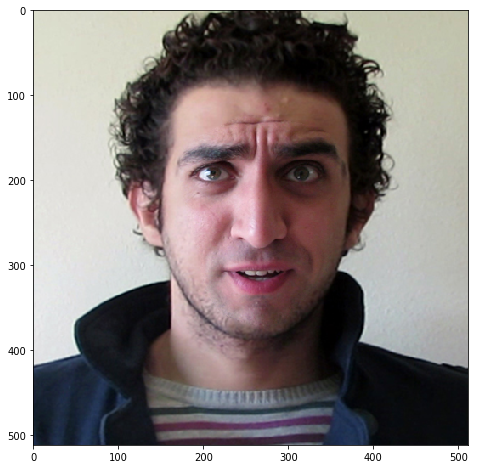

In [78]:
dude1 = cv2.imread('dude1.png')
dude1 = cv2.cvtColor(dude1,cv2.COLOR_BGR2RGB)
dude2 = cv2.imread('dude2.png')
dude2 = cv2.cvtColor(dude2,cv2.COLOR_BGR2RGB)
mask = cv2.imread('mask.png',0)//255
res = pyramidBlendingRGB(dude1,dude2,mask,3,5,5)
res.shape
plt.imshow(res)

In [79]:
# blendingExample1.py
dude1 = cv2.imread('dude1.png')
dude2 = cv2.imread('dude2.png')
mask = (cv2.imread('mask.png',0))
norm_mask = mask//255
res = pyramidBlendingRGB(dude1,dude2,norm_mask,6,5,5)
cv2.imshow('dude1',dude1)
cv2.imshow('dude2',dude2)
cv2.imshow('mask',mask)
cv2.imshow('res',res)
cv2.waitKey()

-1

In [80]:
# blendingExample2.py
robot = cv2.imread('robot.png')
beach = cv2.imread('beach.png')
mask = (cv2.imread('mask2.png',0))
norm_mask = mask//255
res = pyramidBlendingRGB(robot,beach,norm_mask,3,5,5)
cv2.imshow('beach',beach)
cv2.imshow('robot',robot)
cv2.imshow('mask',mask)
cv2.imshow('res',res)
cv2.waitKey()

-1

In [81]:
# blendingExample2.py
shark = cv2.imread('shark.png')
pool = cv2.imread('pool.png')
mask = (cv2.imread('mask3.png',0))
norm_mask = mask//255
res = pyramidBlendingRGB(shark,pool,norm_mask,3,5,5)
cv2.imshow('shark',shark)
cv2.imshow('pool',pool)
cv2.imshow('mask',mask)
cv2.imshow('res',res)
cv2.waitKey()

-1

In [185]:
def xGrad(img):
    ker = np.array([-1,0,1])
    res = np.transpose(img)
    res = cv2.filter2D(res, -1, ker)
    res = np.transpose(res)
    return res

def yGrad(img):
    ker = np.array([-1,0,1])
    res = cv2.filter2D(img, -1, ker)
    return res

def tGrad(i1,i2):
    return i1-i2

In [227]:
i1 = cv2.imread('cars1.jpg',0)
i2 = cv2.imread('cars2.jpg',0)

window_size = 3
u = np.zeros(i1.shape)
v = np.zeros(i1.shape)

xg = xGrad(i1)
yg = yGrad(i1)

for i in range(0,i1.shape[0]-window_size,window_size):
    for j in range(0,i1.shape[1]-window_size,window_size):
        mat1 = i1[i:i+window_size,j:j+window_size]
        mat2 = i2[i:i+window_size,j:j+window_size]
        ix = xg[i:i+window_size,j:j+window_size]
        iy = yg[i:i+window_size,j:j+window_size]
        it = i1[i:i+window_size,j:j+window_size]-i2[i:i+window_size,j:j+window_size]
        A = np.zeros((window_size**2,2))
        b = np.zeros((window_size**2,1))
        for k in range(window_size**2):
            y = int(k/window_size)
            x = k%window_size
            A[k,0] = ix[y,x]
            A[k,1] = iy[y,x]
            b[k,0] = it[y,x]
        det = np.linalg.det(np.transpose(A).dot(A))
        if det != 0:
            vec = np.linalg.inv(np.transpose(A).dot(A)).dot(np.transpose(A)).dot(b)
            u[i,j] = vec[0]
            v[i,j] = vec[1]

# vector_img = i1
# for i in range(0,i1.shape[0],3):
#     for j in range(0,i1.shape[1],3):
#         vector_img = cv2.arrowedLine(vector_img,(i,j),(i-int(u[i,j]/100),j-int(v[i,j]/100)),0)

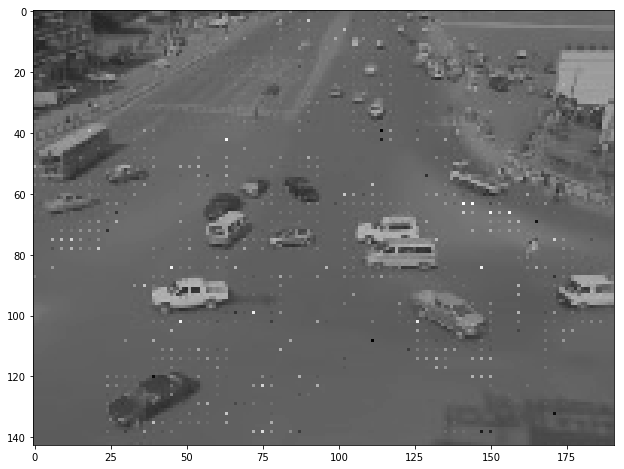

In [237]:
plt.imshow(u+i2,'gray')